# Step 1 - Preprocessing, Demographics, Baseline Pointing Error

In [1]:
%matplotlib inline

import os
import json
import gzip
import pickle
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import trimesh

from palettable.colorbrewer.qualitative import Set1_9, Dark2_5
from helpers import confidence_ellipse


In [2]:
# Paths and constants
COND_COLORS = Set1_9.mpl_colors[0:3]
FB_COLORS = Dark2_5.mpl_colors[0:3]

FOLDER_DATA = '../data'
FOLDER_FIG = '../figures'
FOLDER_OUT = '../stats'

DROP_PPIDS = ['17'] # P17 has invalid data

## Data Import 

In [3]:
def read_all_participant_data(folder, verbose=False, drop_ppids=[]):
    """ Read a folder full of participant data and return aggregated
    trial, sample and event tables plus session info. 
    """
    data_files = glob(os.path.join(folder, 'VRpoint_*.json.gz'))
    
    sessions = []
    trials = None
    samples = None
    events = None

    print('Importing data files...')
    for df in data_files:
        basename = os.path.splitext(df)[0]

        # Get session-specific data from JSON
        with gzip.open(df, mode='rt') as jf:
            exp = json.load(jf)

        ppid = exp['participant']['id']
        if ppid in drop_ppids:
            print('Skipping PPID {:s}.'.format(str(ppid)))
        else:
            # Drop occlusion conditions (not analyzed here)
            occ = exp['trials'][18]['params']['occluded']
            if occ == 'no':
                sd = {'ppid': ppid,
                      'session': exp['participant']['session'],
                      'feedback': exp['trials'][0]['params']['feedback'],
                      'occluded': occ, 
                      'obj_scale': exp['config']['object_scale'],
                      'age': exp['participant']['age'],
                      'gender': exp['participant']['gender'],
                      'gaze_acc': exp['eye_tracker_validations'][0]['acc'],
                      'gaze_rms': exp['eye_tracker_validations'][0]['rmsi'],
                      'gaze_sd': exp['eye_tracker_validations'][0]['sd'],
                      'ipd': exp['eye_tracker_validations'][0]['ipd'],
                      'wrist_cal_x': exp['config']['wrist_cal']['average_offset'][0],
                      'wrist_cal_y': exp['config']['wrist_cal']['average_offset'][1],
                      'wrist_cal_z': exp['config']['wrist_cal']['average_offset'][2],
                      'data_file': os.path.split(basename)[1][0:-4],
                      'in_file': os.path.split(exp['config']['_trial_input_files'][0])[1]}
                sessions.append(sd)

                tr_file = basename[0:-9] + '.tsv.gz'
                sa_file = basename[0:-9] + '_samples.tsv.gz'
                ev_file = basename[0:-9] + '_events.tsv.gz'

                tr = pd.read_csv(tr_file, sep='\t', index_col=False, compression='gzip')
                ev = pd.read_csv(ev_file, sep='\t', index_col=False, compression='gzip')
                sa = pd.read_csv(sa_file, sep='\t', index_col=False, compression='gzip')

                # Add participant metadata to samples DF
                tr.loc[:, 'ppid'] = ppid
                tr.loc[:, 'session'] = exp['participant']['session']
                ev.loc[:, 'ppid'] = ppid
                ev.loc[:, 'session'] = exp['participant']['session']
                sa.loc[:, 'ppid'] = ppid
                sa.loc[:, 'session'] = exp['participant']['session']

                if trials is None:
                    trials = tr
                else:
                    trials = pd.concat([trials, tr])

                if samples is None:
                    samples = sa
                else:
                    samples = pd.concat([samples, sa])

                if events is None:
                    events = ev
                else:
                    events = pd.concat([events, ev])

                if verbose:
                    print([exp['participant']['id'], exp['participant']['session']])

            else:
                if verbose:
                    print('dropped occlusion condition:', [exp['participant']['id'], exp['participant']['session']])
            
    print('Done.')
    sessions = pd.DataFrame(sessions)
    return sessions, trials, samples, events

In [4]:
# Read all data files
sessions, all_trials, samples, events = read_all_participant_data(FOLDER_DATA, drop_ppids=DROP_PPIDS)
print('Found participants:', sessions.ppid.unique())
print('N=' + str(sessions.ppid.unique().shape[0]))

Importing data files...
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Skipping PPID 17.
Done.
Found participants: ['10' '11' '12' '13' '14' '15' '16' '18' '19' '1' '20' '21' '22' '23' '24'
 '25' '2' '3' '4' '5' '6' '7' '8' '9']
N=24


In [5]:
# Set column data types
sessions.loc[:, 'ppid'] = pd.to_numeric(sessions.loc[:, 'ppid']).astype(int)
sessions.loc[:, 'age'] = pd.to_numeric(sessions.loc[:, 'age']).astype(int)
all_trials.loc[:, 'ppid'] = pd.to_numeric(all_trials.loc[:, 'ppid']).astype(int)

# Split trials into calibration and object trials
calibs = all_trials.loc[all_trials.type == 'cal', :].copy(deep=True)
trials = all_trials.loc[all_trials.type == 'obj', :].copy(deep=True)

print(all_trials.shape)
print(calibs.shape)
print(trials.shape)

VALID_PPIDS = sessions.ppid.unique()


(6336, 57)
(1296, 57)
(5040, 57)


C:\Users\Immo\AppData\Local\Temp\ipykernel_8692\1494554511.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sessions.loc[:, 'ppid'] = pd.to_numeric(sessions.loc[:, 'ppid']).astype(int)
C:\Users\Immo\AppData\Local\Temp\ipykernel_8692\1494554511.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sessions.loc[:, 'age'] = pd.to_numeric(sessions.loc[:, 'age']).astype(int)
C:\Users\Immo\AppData\Local\Temp\ipykernel_8692\1494554511.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace i

In [6]:
# Compute session durations
sess_dur = trials.loc[:, ['ppid', 'session', 'trial', '_start_tick', '_end_tick']]
dur = []

for ppid in sess_dur.ppid.unique():
    for sess in sess_dur.loc[sess_dur.ppid == ppid, 'session'].unique():
        df = sess_dur.loc[(sess_dur.ppid == ppid) & (sess_dur.session == sess), :]
        dt = df.iloc[-1, :]._end_tick - df.iloc[0, :]._start_tick
        dur.append({'ppid': ppid, 
                    'session': sess,
                    'duration': dt / 60.0})
dur = pd.DataFrame(dur)
display(dur.duration.describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
duration,72.0,4.063764,0.52954,3.202973,3.675231,3.96154,4.45732,5.661052


## Demographics

See Section Methods / Participants.

In [7]:
# Collect demographics from session data and additional information below
demo = [{'ppid': 1, 'vision': 'contacts', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 2, 'vision': 'no', 'EHI': 25, 'eyedom': 'right'},
        {'ppid': 3, 'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 4, 'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 5, 'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 6, 'vision': 'contacts', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 7, 'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 8, 'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 9, 'vision': 'no', 'EHI': 25, 'eyedom': 'right'},
        {'ppid': 10,'vision': 'contacts', 'EHI': 66.66, 'eyedom': 'right'},
        {'ppid': 11,'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 12,'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 13,'vision': 'no', 'EHI': 50, 'eyedom': 'left'},
        {'ppid': 14,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 15,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 16,'vision': 'contacts', 'EHI': 91.6, 'eyedom': 'right'},
        #{'ppid': 17,'vision': 'contacts', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 18,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 19,'vision': 'no', 'EHI': 66.66, 'eyedom': 'right'},
        {'ppid': 20,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 21,'vision': 'no', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 22,'vision': 'glasses', 'EHI': 100, 'eyedom': 'right'},
        {'ppid': 23,'vision': 'glasses', 'EHI': 83.3, 'eyedom': 'right'},
        {'ppid': 24,'vision': 'no', 'EHI': 83.3, 'eyedom': 'left'},
        {'ppid': 25,'vision': 'no', 'EHI': 100, 'eyedom': 'right'}]

demo = pd.DataFrame(demo)
demo = demo.merge(sessions.loc[sessions.session == '1', ('ppid', 'age', 'gender', 'ipd', 'gaze_acc', 'gaze_sd')],
                  on='ppid', 
                  how='left')

display(demo.loc[:, ('age', 'EHI', 'ipd', 'gaze_acc')].describe().T.round(2))
display(demo.gender.value_counts().to_frame().T)
display(demo.eyedom.value_counts().to_frame().T)
display(demo.vision.value_counts().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
age,24.0,24.04,4.44,20.00,21.00,23.00,24.00,36.00
EHI,24.0,83.67,22.45,25.00,83.30,87.45,100.00,100.00
ipd,24.0,61.06,3.62,53.93,58.26,61.40,64.52,66.28
gaze_acc,24.0,0.77,0.26,0.43,0.53,0.74,0.95,1.32


,female,male
gender,16,8


,right,left
eyedom,17,7


,no,contacts,glasses
vision,16,6,2


## 3D Coordinate Alignment

In [8]:
# Calculate rotated gaze and raycast endpoints in 3d space,
# this aligns EFRC data with the correct object viewing angle
EFRC_COLS = ['efrc_posX_rot',  'efrc_posY_rot',  'efrc_posZ_rot',  # origin - binocular
             'efrc_vecX_rot',  'efrc_vecY_rot',  'efrc_vecZ_rot',  # direction - binocular
             'efrcL_posX_rot', 'efrcL_posY_rot', 'efrcL_posZ_rot', # origin - left eye
             'efrcL_vecX_rot', 'efrcL_vecY_rot', 'efrcL_vecZ_rot', # direction - right eye
             'efrcR_posX_rot', 'efrcR_posY_rot', 'efrcR_posZ_rot', # origin - right eye
             'efrcR_vecX_rot', 'efrcR_vecY_rot', 'efrcR_vecZ_rot', # direction - right eye
             'efrcD_posX_rot', 'efrcD_posY_rot', 'efrcD_posZ_rot', # origin - DOMINANT eye
             'efrcD_vecX_rot', 'efrcD_vecY_rot', 'efrcD_vecZ_rot'] # direction - DOMINANT eye
trials.loc[:, EFRC_COLS] = np.nan

# EFRC 3D endpoint on the object (recorded upon button press)
efrc_coords = trials.loc[:, ('efrc_x', 'efrc_y', 'efrc_z')].values
efrcL_coords = trials.loc[:, ('efrcL_x', 'efrcL_y', 'efrcL_z')].values
efrcR_coords = trials.loc[:, ('efrcR_x', 'efrcR_y', 'efrcR_z')].values

# Normalize 3D endpoints so table height equals zero
efrc_coords[:, 1] = efrc_coords[:, 1] - trials.table_height
efrcL_coords[:, 1] = efrcL_coords[:, 1] - trials.table_height
efrcR_coords[:, 1] = efrcR_coords[:, 1] - trials.table_height

# EFRC direction vector
efrc_dir = trials.loc[:, ('efrc_dir_x', 'efrc_dir_y', 'efrc_dir_z')].values
efrcL_dir = trials.loc[:, ('efrcL_dir_x', 'efrcL_dir_y', 'efrcL_dir_z')].values
efrcR_dir = trials.loc[:, ('efrcR_dir_x', 'efrcR_dir_y', 'efrcR_dir_z')].values

# Apply correct rotation to all groups of data points
oris = trials.obj_angle.unique()
for o in oris:
    if np.isnan(o):
        continue

    # For DATA rotation, rotate against original object angle
    R = trimesh.transformations.euler_matrix(np.deg2rad(1 * o), 0, 0, 'ryzx')[:3, :3]

    # Binocular
    efrc_rotated = np.matmul(efrc_coords[trials.obj_angle == o, :], R)
    efrc_dir_rot = np.matmul(efrc_dir[trials.obj_angle == o, :], R)
    trials.loc[trials.obj_angle == o, 'efrc_posX_rot'] = efrc_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrc_posY_rot'] = efrc_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrc_posZ_rot'] = efrc_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrc_vecX_rot'] = efrc_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrc_vecY_rot'] = efrc_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrc_vecZ_rot'] = efrc_dir_rot[:, 2]
    
    # Left eye
    efrcL_rotated = np.matmul(efrcL_coords[trials.obj_angle == o, :], R)
    efrcL_dir_rot = np.matmul(efrcL_dir[trials.obj_angle == o, :], R)
    trials.loc[trials.obj_angle == o, 'efrcL_posX_rot'] = efrcL_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcL_posY_rot'] = efrcL_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcL_posZ_rot'] = efrcL_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrcL_vecX_rot'] = efrcL_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcL_vecY_rot'] = efrcL_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcL_vecZ_rot'] = efrcL_dir_rot[:, 2]

    # Right eye
    efrcR_rotated = np.matmul(efrcR_coords[trials.obj_angle == o, :], R)
    efrcR_dir_rot = np.matmul(efrcR_dir[trials.obj_angle == o, :], R)    
    trials.loc[trials.obj_angle == o, 'efrcR_posX_rot'] = efrcR_rotated[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcR_posY_rot'] = efrcR_rotated[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcR_posZ_rot'] = efrcR_rotated[:, 2]
    trials.loc[trials.obj_angle == o, 'efrcR_vecX_rot'] = efrcR_dir_rot[:, 0]
    trials.loc[trials.obj_angle == o, 'efrcR_vecY_rot'] = efrcR_dir_rot[:, 1]
    trials.loc[trials.obj_angle == o, 'efrcR_vecZ_rot'] = efrcR_dir_rot[:, 2]

# Select dominant eye data - copy the correct eye per participant
for pp in trials.ppid.unique():
    dom_eye = demo.loc[demo.ppid == pp, 'eyedom'].str.upper().values[0][0]
    for col in ['efrcD_posX_rot', 'efrcD_posY_rot', 'efrcD_posZ_rot',
                'efrcD_vecX_rot', 'efrcD_vecY_rot', 'efrcD_vecZ_rot']:
        
        eyecol = col[0:4] + dom_eye + col[5:]
        trials.loc[trials.ppid == pp, col] = trials.loc[trials.ppid == pp, eyecol]


In [9]:
# Drop all raycasts that "missed" the object and went to the wall or floor
BOX = 0.5 # +/- around object, in m
MIN_HEIGHT = 0.01 # remove floor fixations

for eye in ['', 'L', 'R', 'D']:
    filter_x = np.abs(trials.loc[:, 'efrc{:s}_posX_rot'.format(eye)]) >= BOX
    print('Filtered due to X coordinate ({:s}): {:d} /{:d}'.format(eye, trials.loc[filter_x, :].shape[0], trials.shape[0]))
    trials.loc[filter_x, 'efrc{:s}_posX_rot'.format(eye)] = np.nan
          
    filter_y = np.abs(trials.loc[:, 'efrc{:s}_posY_rot'.format(eye)]) <= MIN_HEIGHT
    print('Filtered due to Y coordinate (floor fixations; {:s}): {:d} /{:d}'.format(eye, trials.loc[filter_y, :].shape[0], trials.shape[0]))
    trials.loc[filter_y, 'efrc{:s}_posY_rot'.format(eye)] = np.nan
    
    filter_z = np.abs(trials.loc[:, 'efrc{:s}_posZ_rot'.format(eye)]) >= BOX
    print('Filtered due to Z coordinate (floor fixations; {:s}): {:d} /{:d}'.format(eye, trials.loc[filter_z, :].shape[0], trials.shape[0]) )
    trials.loc[filter_z, 'efrc{:s}_posZ_rot'.format(eye)] = np.nan


Filtered due to X coordinate (): 204 /5040
Filtered due to Y coordinate (floor fixations; ): 46 /5040
Filtered due to Z coordinate (floor fixations; ): 275 /5040
Filtered due to X coordinate (L): 178 /5040
Filtered due to Y coordinate (floor fixations; L): 40 /5040
Filtered due to Z coordinate (floor fixations; L): 243 /5040
Filtered due to X coordinate (R): 283 /5040
Filtered due to Y coordinate (floor fixations; R): 67 /5040
Filtered due to Z coordinate (floor fixations; R): 368 /5040
Filtered due to X coordinate (D): 242 /5040
Filtered due to Y coordinate (floor fixations; D): 63 /5040
Filtered due to Z coordinate (floor fixations; D): 326 /5040


## Baseline Pointing & Gaze Accuracy

In [10]:
# Calculate pointing and gaze errors relative to known wall targets

# Combined Raycast
calibs.loc[:, 'point_errX'] = np.abs(calibs.loc[:, 'efrc_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_errY'] = np.abs(calibs.loc[:, 'efrc_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_err'] = np.hypot(calibs.loc[:, 'efrc_x'] - calibs.loc[:, 'tar_x'], 
                                      calibs.loc[:, 'efrc_y'] - calibs.loc[:, 'tar_y'])
# Left and right eye Raycasts
calibs.loc[:, 'point_err_xL'] = np.abs(calibs.loc[:, 'efrcL_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_err_yL'] = np.abs(calibs.loc[:, 'efrcL_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_errL'] = np.hypot(calibs.loc[:, 'efrcL_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'efrcL_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_err_xR'] = np.abs(calibs.loc[:, 'efrcR_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'point_err_yR'] = np.abs(calibs.loc[:, 'efrcR_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'point_errR'] = np.hypot(calibs.loc[:, 'efrcR_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'efrcR_y'] - calibs.loc[:, 'tar_y'])
# Dominant eye raycast
# Select dominant eye data - copy the correct eye per participant
for pp in calibs.ppid.unique():
    dom_eye = demo.loc[demo.ppid == pp, 'eyedom'].str.upper().values[0][0]
    
    calibs.loc[calibs.ppid == pp, 'efrcD_x'] = calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)]
    calibs.loc[calibs.ppid == pp, 'efrcD_y'] = calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)]

    calibs.loc[calibs.ppid == pp, 'point_err_xD'] = np.abs(calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_x'])
    calibs.loc[calibs.ppid == pp, 'point_err_yD'] = np.abs(calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_y'])
    calibs.loc[calibs.ppid == pp, 'point_errD'] = np.hypot(calibs.loc[calibs.ppid == pp, 'efrc{:s}_x'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_x'], 
                                        calibs.loc[calibs.ppid == pp, 'efrc{:s}_y'.format(dom_eye)] - calibs.loc[calibs.ppid == pp, 'tar_y'])

# Gaze
calibs.loc[:, 'gaze_errX'] = np.abs(calibs.loc[:, 'gaze_x'] - calibs.loc[:, 'tar_x'])
calibs.loc[:, 'gaze_errY'] = np.abs(calibs.loc[:, 'gaze_y'] - calibs.loc[:, 'tar_y'])
calibs.loc[:, 'gaze_err'] = np.hypot(calibs.loc[:, 'gaze_x'] - calibs.loc[:, 'tar_x'], 
                                        calibs.loc[:, 'gaze_y'] - calibs.loc[:, 'tar_y'])


In [11]:
# Drop all baseline trials with missing gaze data
MISS = -99999
calibs_old_n = calibs.shape[0]
cgaze_missing = (calibs.gaze_x <= MISS) | (calibs.gaze_y <= MISS) | (calibs.gaze_z <= MISS)
calibs = calibs.loc[~cgaze_missing]
print('Dropped {:d}/{:d} calibration trials due to missing gaze data at response!'.format(np.sum(cgaze_missing), calibs_old_n))


Dropped 17/1296 calibration trials due to missing gaze data at response!


In [12]:
# Outlier Correction: Drop baseline errors +/- 3SD
CAL_OUTLIER_SD = 3.0
CVARS = ['point_errX', 'point_errY', 'point_err', 
         'point_err_xL', 'point_err_yL', 'point_errL', 
         'point_err_xR', 'point_err_yR', 'point_errR',
         'point_err_xD', 'point_err_yD', 'point_errD',
         'gaze_errX', 'gaze_errY', 'gaze_err']

prev = calibs.shape[0]
for var in CVARS:
    var_m = calibs.loc[:, var].mean()
    var_sd = calibs.loc[:, var].std()
    var_out = (calibs.loc[:, var] <= var_m - (CAL_OUTLIER_SD * var_sd)) | (calibs.loc[:, var] >= var_m + (CAL_OUTLIER_SD * var_sd))
    #print(var, np.round(var_m, 3), np.round(var_sd, 3), np.round(var_out.sum(), 3))
    calibs.loc[var_out, var] = np.nan
    
    if var == 'point_errD':
        # Filter variable based on pointing error outliers
        pe_filter = var_out.copy()

calibs.loc[:, 'cal_outlier'] = pe_filter.astype(int)

print('Dropped {:d}/{:d} baseline trials as outliers!'.format(pe_filter.sum(), prev))

Dropped 16/1279 baseline trials as outliers!


In [13]:
# Figure parameters
PAPER_FIGSIZE_FC = 3.75
SMALL_MARKER_ALPHA = 0.1
SMALL_MARKER_SIZE = 3
AVG_MARKER_ALPHA = 1
AVG_MARKER_SIZE = 5
TAR_MARKER_SIZE = 8
ELLIPSE_LW = 1.2
FB_LABELS = {'hand': 'Virtual Hand',
             'cursor': 'Cursor Sphere',
             'none': 'No Feedback'}
FB_MARKERS = {'hand': 'v',
             'cursor': 'o',
             'none': '^'}

In [14]:
def plot_baseline_errors(calibs, figsize=(3.75, 3.75), xlimits=(-1.5, 1.5), ylimits=(0, 3.5), dodge=0.05, metric_dodge=0.25):
    """ Plot pointing and gaze calibration data """
    
    METRICS = ['point_err', 'point_errL', 'point_errR', 'point_errD']
    METRIC_MARKERS = {'point_err': 'D', 
                      'point_errL': '<', 
                      'point_errR': '>', 
                      'point_errD': 'o'}
    METRIC_LABELS = {'point_err': 'Binocular', 
                      'point_errL': 'Left Eye', 
                      'point_errR': 'Right Eye', 
                      'point_errD': 'Dominant Eye'}
    
    handles = []
    labels = []
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150, 
                           subplot_kw={'facecolor': 'none'})
    # Left Figure: Pointing
    for ix, fb in enumerate(['cursor', 'hand', 'none']):
        
        metric_x = np.linspace(-metric_dodge, +metric_dodge, len(METRICS))
        for mix, metric in enumerate(METRICS):
            
            # By-Participant Data
            for ppid in VALID_PPIDS:

                tr = calibs.loc[(calibs.ppid == ppid) & (calibs.feedback == fb) & (calibs.cal_outlier == 0), :]

                # Average calibration error per ppid, feedback and target
                ax.plot(ix + 1 + metric_x[mix] + (dodge * (np.random.random() - 0.5)), 
                        np.nanmean(tr.loc[:, metric]) * 100.0, 
                        marker=METRIC_MARKERS[metric], 
                        markersize=SMALL_MARKER_SIZE, 
                        color=FB_COLORS[ix], alpha=SMALL_MARKER_ALPHA)

            # Across-participant + target average + SEM
            all_err = calibs.loc[(calibs.feedback == fb) & (calibs.cal_outlier == 0), ('ppid', metric)] \
                            .groupby(['ppid'], as_index=False) \
                            .agg('mean') \
                            .loc[:, metric]
            m = np.nanmean(all_err)
            sem = np.nanstd(all_err) / np.sqrt(tr.ppid.unique().shape[0]) / 4
            
            h = ax.errorbar(x=ix+1 + metric_x[mix], 
                            y=m * 100.0, 
                            yerr=sem  * 100.0, 
                            marker=METRIC_MARKERS[metric], 
                            markersize=AVG_MARKER_SIZE, 
                            alpha=AVG_MARKER_ALPHA, 
                            color=FB_COLORS[ix], 
                            markeredgecolor='k',
                            ecolor=FB_COLORS[ix],
                            linewidth=1.2)
            
            if ix == 0:
                handles.append(h)
                labels.append(METRIC_LABELS[metric])

    ax.set_xlim([0.5, 3.5])
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Sphere', 'Hand', 'None'])
    ax.set_xlabel('Visual Feedback', fontsize=11)
    ax.set_ylabel('Pointing Error (cm)', fontsize=11)
    ax.legend(handles, labels, loc='upper left', frameon=False, title='Vector Origin', fontsize=8)
    
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0)

    
    plt.tight_layout()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05)


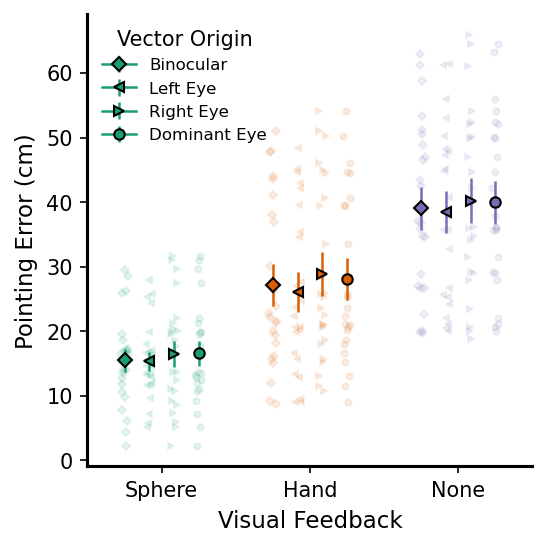

In [15]:
# Figure: Baseline pointing error
plot_baseline_errors(calibs)
plt.tight_layout()
plt.savefig(os.path.join(FOLDER_FIG, 'baseline_pointing_error.png'), dpi=150)

In [16]:
# Export baseline accuracy for LMM analysis (to be analyzed in Jamovi)
BL_COLS = ['ppid', 'session', '_original_idx', 'feedback', 'point_err', 'point_errL', 'point_errR', 'point_errD']
lmm_baseline = calibs.loc[calibs.cal_outlier == 0, BL_COLS] \
                     .rename(columns={'_original_idx': 'trial'}) \
                     .melt(id_vars=['ppid', 'session', 'trial', 'feedback'])
lmm_baseline.to_csv(os.path.join(FOLDER_OUT, 'lmm_baseline_error.csv'), sep='\t', index=False)

## Save Preprocessed Data

In [17]:
# Save preprocessed datasets
sessions.to_csv(os.path.join(FOLDER_OUT, 'all_sessions.tsv'), sep='\t', index=False)
trials.to_csv(os.path.join(FOLDER_OUT, 'all_trials.tsv'), sep='\t', index=False)

# Save temporary pickle files
with open(os.path.join(FOLDER_OUT, 'all_sessions.pkl'), 'wb') as pf:
    pickle.dump(sessions, pf)
with open(os.path.join(FOLDER_OUT, 'all_trials.pkl'), 'wb') as pf:
    pickle.dump(trials, pf)
with open(os.path.join(FOLDER_OUT, 'all_calibs.pkl'), 'wb') as pf:
    pickle.dump(calibs, pf)
